In [31]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [32]:
models = {
#     "GloVe": "baseline",
#     "ConvS2S": "fairseq.wmt14.en-fr.fconv",
#     "InferSent": "infersent.allnli",
#     "IMDB": "imdbsentiment",
#     "skipthought": "skipthought",
#     "DisSent": "dissent.books8.epoch9",
#     "order": "order-embeddings",
#     "ELMo": "elmo.2x4096",
#     "BERT": "bert.base",
# #     "BERT Large": "bert.base-large",
#     "BERT-MRPC": "bert.base.finetune-MRPC",
#     "BERT-CoLA": "bert.base.finetune-CoLA",
#     "BERT-MNLI": "bert.base.finetune-MNLI",
#     "BERT-RTE": "bert.base.finetune-RTE",
#     "BERT-SST": "bert.base.finetune-SST",
#     "BERT-WNLI": "bert.base.finetune-WNLI",
#     "BERT-QQP": "bert.base.finetune-QQP",
#     "BERT-SNLI": "bert.base.finetune-SNLI",
#     "openai": "transformer.roc",
    
    "BERT": "bert.base",
#     "BERT Large": "bert.base-large",
    "BERT-MRPC": "bert.base.finetune-5000-MRPC",
    "BERT-CoLA": "bert.base.finetune-5000-CoLA",
    "BERT-MNLI": "bert.base.finetune-5000-MNLI",
    "BERT-RTE": "bert.base.finetune-5000-RTE",
    "BERT-SST": "bert.base.finetune-5000-SST",
    "BERT-WNLI": "bert.base.finetune-5000-WNLI",
#     "BERT-QQP": "bert.base.finetune-5000-QQP",
    "BERT-SNLI": "bert.base.finetune-5000-SNLI",
}

In [33]:
def analyze_encoding(name, results_path):
    df = pd.read_csv(results_path, index_col=[0, 1])
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.violinplot(x="subject", y="value", hue="type", data=df.reset_index().melt(id_vars=["subject", "type"], value_vars=["mar_fold_%i" % i for i in range(18)]), ax=ax)
    plt.ylim((40, 260))
    plt.ylabel("average rank")
    plt.title("%s: Within-subject MAR" % name)
    
    subj_perf = df.groupby("type").apply(lambda sub_df: sub_df.reset_index(level=0, drop=True).mean(axis=1)).T
    subj_perf.plot.bar(title="%s: Within-subject MAR" % name)
    
    return subj_perf

In [34]:
stats = {}

--------

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


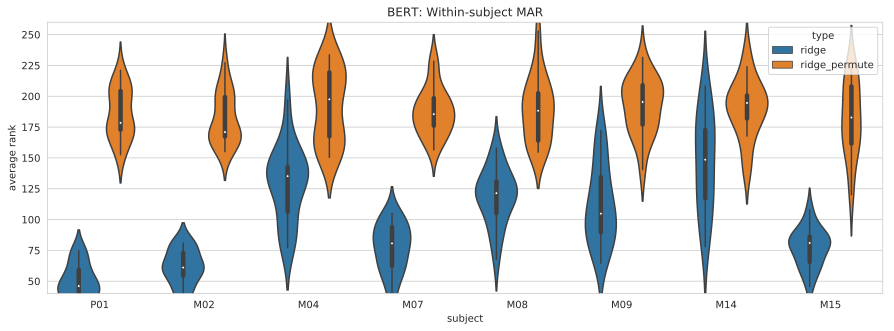

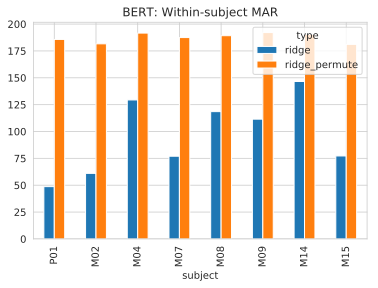

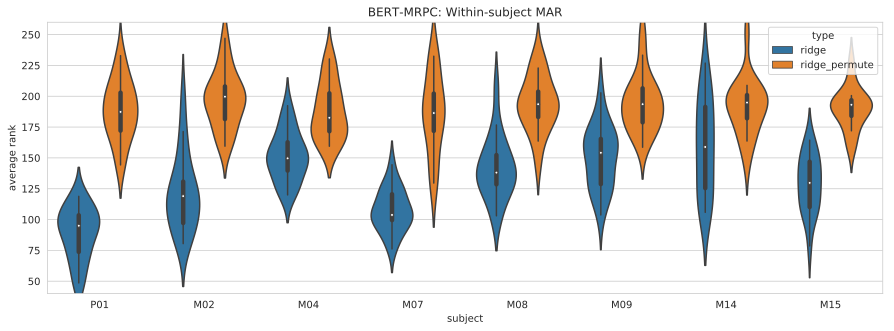

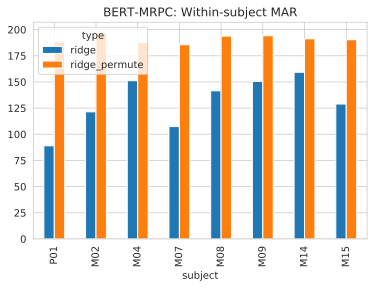

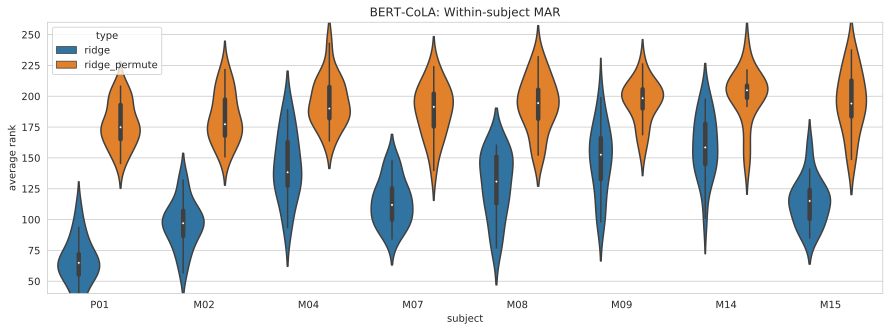

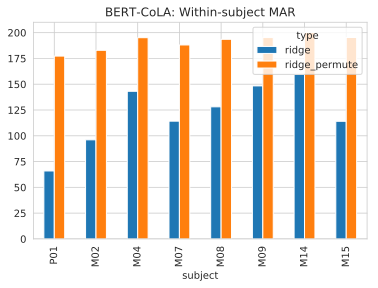

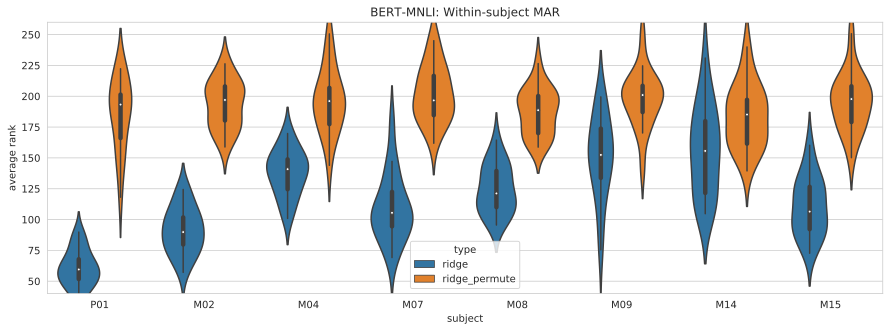

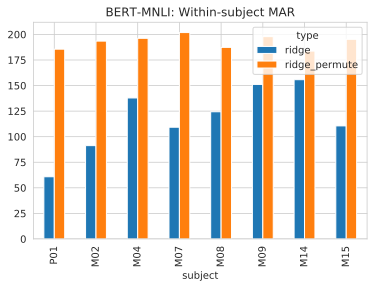

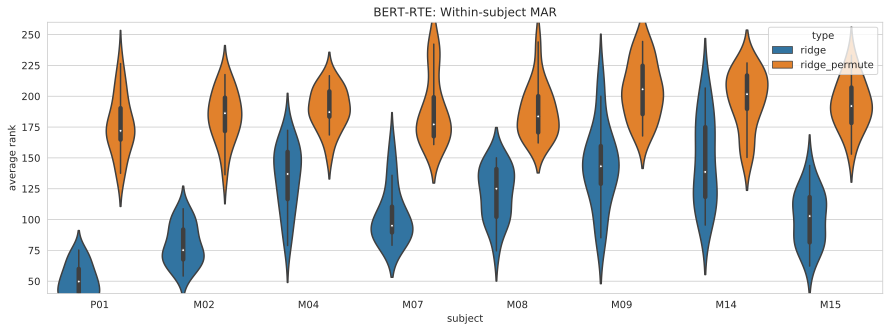

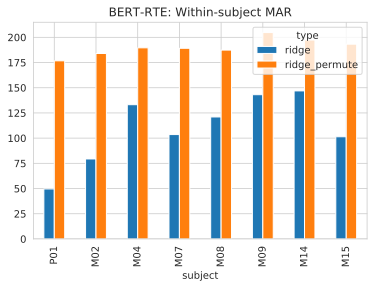

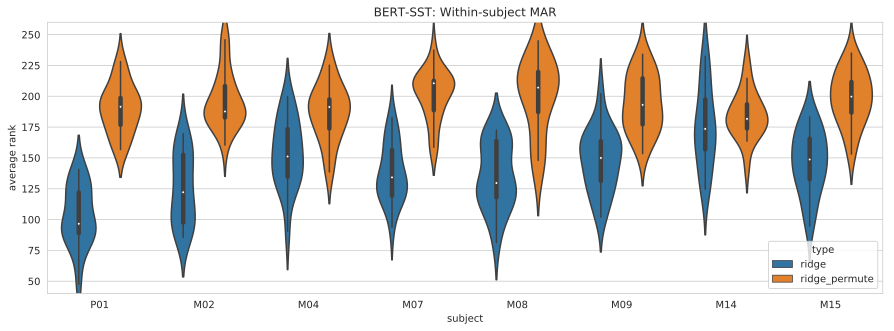

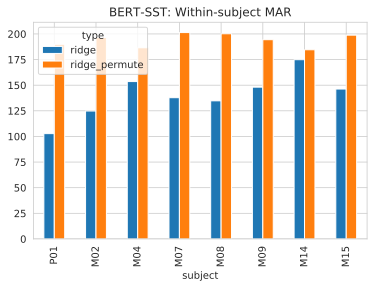

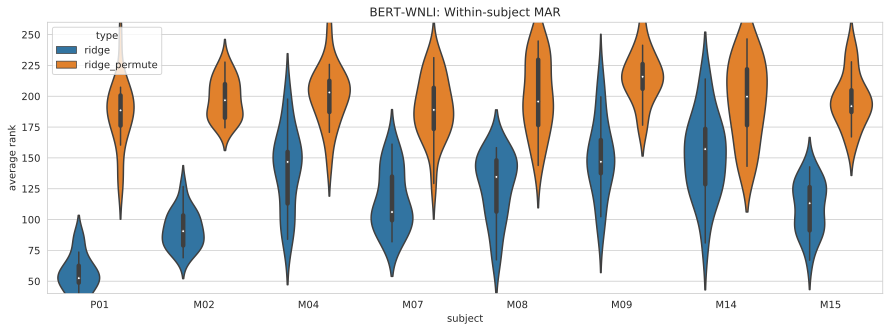

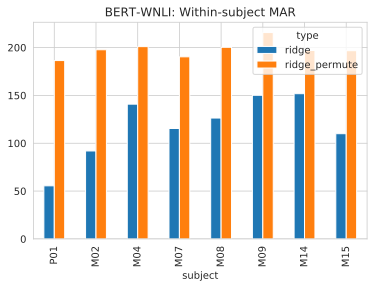

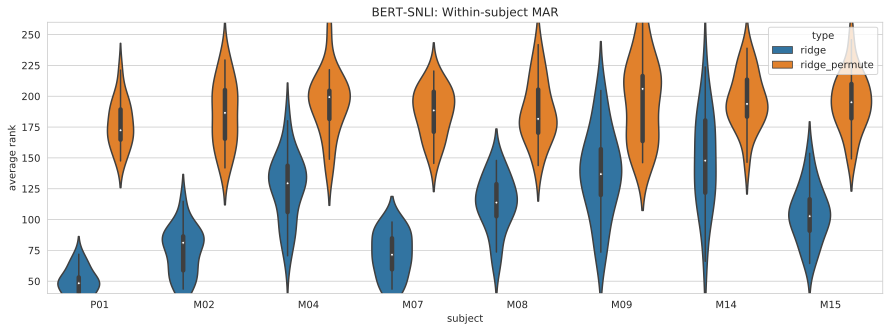

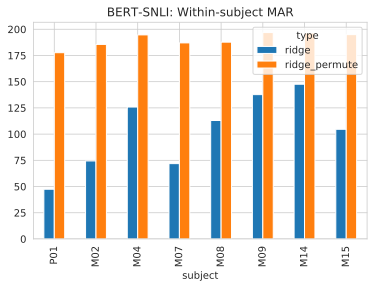

In [35]:
for model, path in models.items():
    try:
        stats[model] = analyze_encoding(model, "perf.384sentences.%s.csv" % path)
    except: pass

-----

# Pairwise statistical tests

We'll calculate which model pair differences in performance are significant by the Wilcoxon test on the original sentence-rank data. (The data graphed above are all computed from MAR statistics (meaned across sentences).)

In [36]:
# Aggregate statistics.
f = pd.concat(stats, names=["target", "subject"]).reset_index()

In [37]:
f.head()

type,target,subject,ridge,ridge_permute
0,BERT,P01,48.703704,185.690476
1,BERT,M02,61.005291,181.613757
2,BERT,M04,129.359788,191.584656
3,BERT,M07,76.989418,187.447090
4,BERT,M08,118.492063,189.187831


In [38]:
# Load full model predictions.
model_preds = {model: pd.read_csv("perf.384sentences.%s.pred.csv" % model_path).sort_index() for model, model_path in models.items()}

In [39]:
from scipy.stats import wilcoxon
import itertools

wilcoxon_results = []
for (model1_name, model1), (model2_name, model2) in itertools.combinations(model_preds.items(), 2):
    w_stat, p_val = wilcoxon(model1["rank"], model2["rank"])
    wilcoxon_results.append((model1_name, model2_name, w_stat, p_val))
    
wilcoxon_results = pd.DataFrame(wilcoxon_results, columns=["model1", "model2", "w_stat", "p_val"]).set_index(["model1", "model2"])
# Bonferroni correction
correction = len(list(itertools.combinations(model_preds.items(), 2)))
wilcoxon_results["significant_bonferroni"] = wilcoxon_results["p_val"] < 0.01 / correction

In [40]:
wilcoxon_results.sort_values("p_val")

w_stat          p_val  significant_bonferroni
model1    model2                                                     
BERT      BERT-SST   1234053.0  1.064486e-100                    True
          BERT-WNLI  1322059.5   2.504756e-80                    True
BERT-SST  BERT-SNLI  1356113.5   4.917244e-78                    True
BERT      BERT-MRPC  1351560.0   1.832088e-76                    True
          BERT-CoLA  1390947.5   2.790161e-68                    True
          BERT-MNLI  1469133.0   1.715165e-56                    True
BERT-RTE  BERT-SST   1548970.0   4.904698e-49                    True
BERT      BERT-RTE   1491981.0   2.894764e-48                    True
BERT-MRPC BERT-SNLI  1546855.0   3.752508e-47                    True
BERT-MNLI BERT-SNLI  1580536.5   4.223024e-39                    True
BERT-WNLI BERT-SNLI  1615440.0   1.274926e-35                    True
BERT-CoLA BERT-SNLI  1638815.0   4.013735e-35                    True
BERT-MRPC BERT-RTE   1677160.5   2.234426e-31                    True
BERT-MNLI BERT-SST   1720008.0   3.546838e-29                    True
BERT-SST  BERT-WNLI  1756479.5   1.421021e-24                    True
BERT-CoLA BERT-RTE   1838553.5   5.014078e-16                    True
          BERT-SST   1865030.0   1.330901e-15                    True
BERT-RTE  BERT-WNLI  1840891.5   5.644497e-15                    True
          BERT-SNLI  1871249.5   1.467798e-12                    True
BERT-MRPC BERT-MNLI  1925834.0   1.347049e-11                    True
          BERT-WNLI  1920598.0   2.973737e-11                    True
BERT-MNLI BERT-RTE   1897975.5   4.393754e-11                    True
BERT      BERT-SNLI  1935845.0   5.565793e-08                    True
BERT-MRPC BERT-CoLA  2010936.5   2.332149e-07                    True
          BERT-SST   2088957.5   3.717325e-04                   False
BERT-CoLA BERT-MNLI  2149384.5   6.279052e-02                   False
          BERT-WNLI  2143536.0   8.212922e-02                   False
BERT-MNLI BERT-WNLI  2184566.5   3.370559e-01                   False

---------

# Aggregate graphs

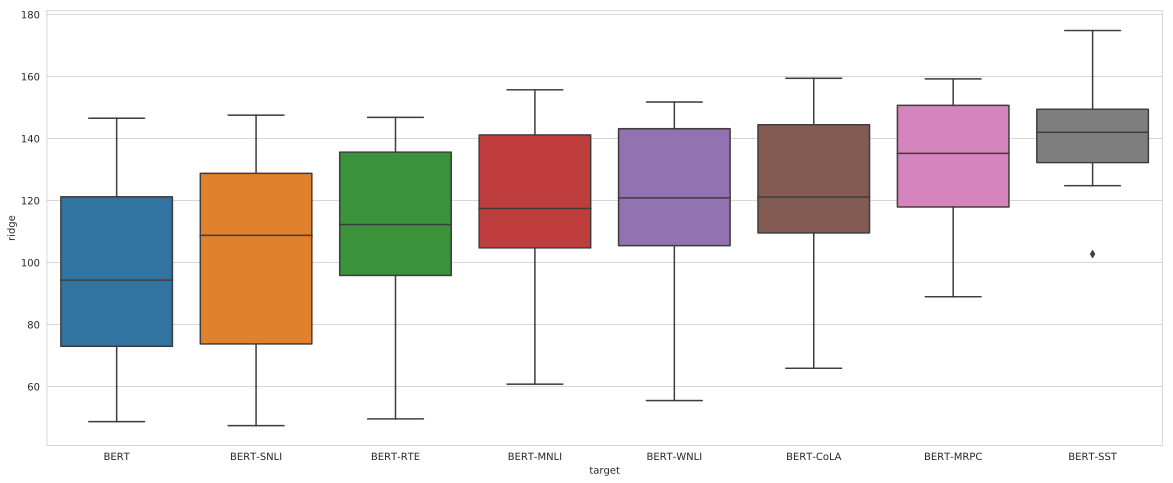

In [41]:
fig, ax = plt.subplots(figsize=(20, 8))

target_order = f.groupby("target").ridge.agg("mean").argsort()
sns.boxplot(x="target", y="ridge", data=f, ax=ax, order=target_order.index[target_order])

In [42]:
f.groupby("target").ridge.agg("mean")

target
BERT          96.226190
BERT-CoLA    121.166005
BERT-MNLI    117.606812
BERT-MRPC    131.154431
BERT-RTE     109.732804
BERT-SNLI    102.777447
BERT-SST     140.350529
BERT-WNLI    117.740079
Name: ridge, dtype: float64

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[-0.4  0.6  1.6  2.6  3.6  4.6  5.6  6.6  0. ]


Text(0.87, -0.025, '* = p<0.01 for Bonferroni-corrected Wilcoxon test')

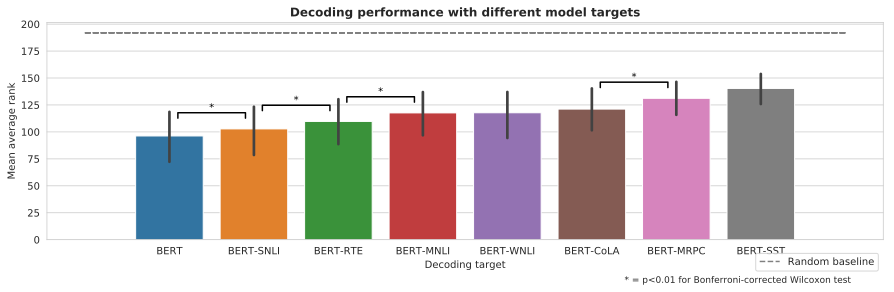

In [43]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x="target", y="ridge", order=target_order.index[target_order], data=f)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance with different model targets", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.04))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
mean_results = f.groupby("target").ridge.agg("mean")
for (m1_pos, m1_label), (m2_pos, m2_label) in zip(xticks, xticks[1:]):
    m1_label = m1_label.get_text()
    m2_label = m2_label.get_text()
    try:
        significant = wilcoxon_results.loc[m1_label, m2_label].significant_bonferroni
    except:
        significant = wilcoxon_results.loc[m2_label, m1_label].significant_bonferroni
    
    if significant:
        y = max(mean_results[m1_label], mean_results[m2_label]) + 10
        h = 5
        col = 'k'
        plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)
        
plt.figtext(0.87, -0.025, "* = p<0.01 for Bonferroni-corrected Wilcoxon test", wrap=True, horizontalalignment='right', fontsize=9)

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Decoding performance between subjects')

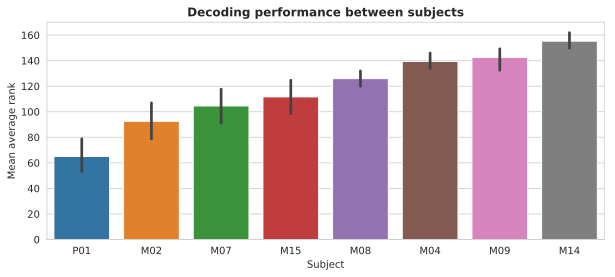

In [44]:
order = f.groupby("subject").ridge.agg("mean").argsort()
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="subject", y="ridge", order=order.index[order], data=f, ax=ax)
plt.xlabel("Subject")
plt.ylabel("Mean average rank")
plt.title("Decoding performance between subjects", weight="bold")